In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transactions = pd.read_csv("transactions.csv")

In [3]:
# Säkerställ att TransactionDate är i datetime-format
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

In [4]:
# Sortera transaktioner per kund och datum
transactions = transactions.sort_values(by=["CustomerID", "TransactionDate"])

In [5]:
# Skapa funktioner för varje kunds senaste köpdata
def create_features(group):
    group["PrevCategory"] = group["Category"].shift(1)  # Senaste köpkategori
    group["TimeSinceLastPurchase"] = (
        group["TransactionDate"] - group["TransactionDate"].shift(1)
    ).dt.days  # Dagar sedan senaste köp
    group["AvgAmount"] = group["Amount"].expanding().mean()  # Genomsnittligt köpbelopp
    return group

In [6]:
transactions = transactions.groupby("CustomerID").apply(create_features)

C:\Users\danne\AppData\Local\Temp\ipykernel_53140\4020933603.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions = transactions.groupby("CustomerID").apply(create_features)


In [7]:
transactions = transactions.dropna()

In [8]:
transactions["PrevCategory"] = transactions["PrevCategory"].astype("category").cat.codes
transactions["Category"] = transactions["Category"].astype("category").cat.codes

In [9]:
X = transactions[["PrevCategory", "TimeSinceLastPurchase", "AvgAmount"]]
y = transactions["Category"]

In [10]:
# Dela upp data i tränings- och testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Skapa och träna modellen
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Gör prediktioner
y_pred = rf_model.predict(X_test)

In [13]:
# Utvärdera modellen
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        10
           1       0.57      0.31      0.40        13
           2       0.17      0.33      0.22         3
           3       0.20      0.40      0.27         5

    accuracy                           0.29        31
   macro avg       0.30      0.31      0.28        31
weighted avg       0.37      0.29      0.30        31



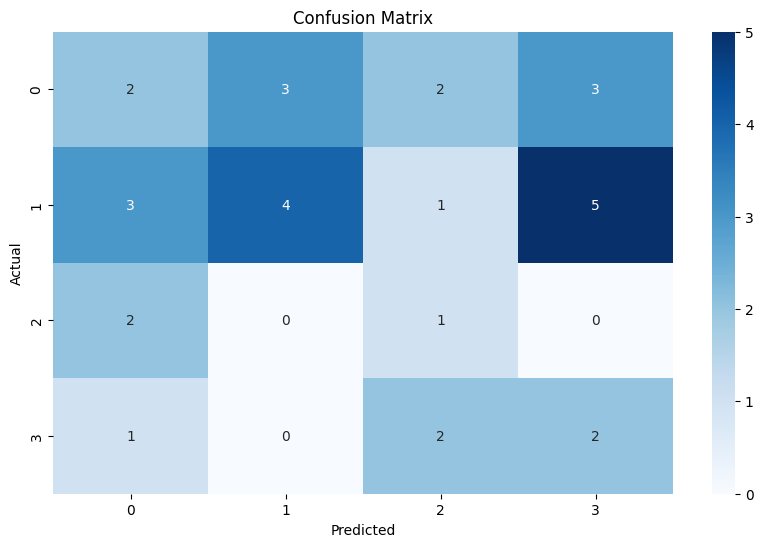

In [14]:
# Konfusionsmatris
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Kod för att visa nästa köp-förutsägelser:

In [16]:
# Skapa en DataFrame för att visa verkliga och förutsagda kategorier
results = X_test.copy()
results["ActualCategory"] = y_test.values
results["PredictedCategory"] = y_pred

# Lägg till kategorinamn om du har dem
category_mapping = {0: "Electronics", 1: "Clothing", 2: "Groceries", 3: "Health"}
results["ActualCategoryName"] = results["ActualCategory"].map(category_mapping)
results["PredictedCategoryName"] = results["PredictedCategory"].map(category_mapping)

# Visa några exempel
print(results.head(10))


                PrevCategory  TimeSinceLastPurchase   AvgAmount  \
CustomerID                                                        
3920       689             1                    5.0  153.410000   
2907       704             2                   15.0  402.150000   
3448       728             2                   27.0  211.270000   
           738             0                    0.0  205.223333   
2572       68              2                    0.0  238.180000   
2478       720             2                   29.0  278.015000   
2021       482             2                   10.0  115.605000   
2567       872             0                   17.0  378.853333   
1493       107             0                    1.0  220.255000   
1053       561             3                    5.0  160.515000   

                ActualCategory  PredictedCategory ActualCategoryName  \
CustomerID                                                             
3920       689               3                  0  

 # Konfusionsmatris

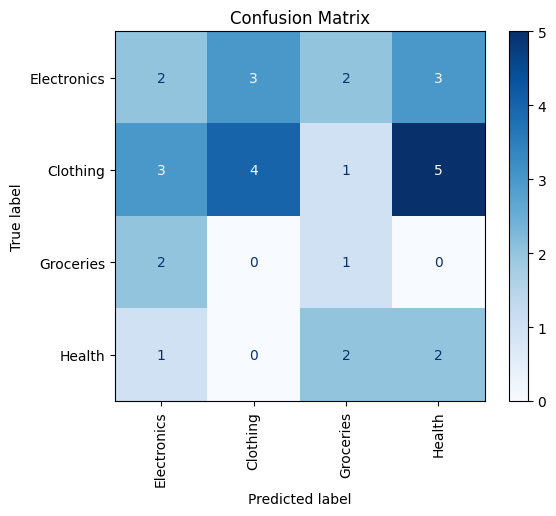

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Skapa konfusionsmatris
conf_matrix = confusion_matrix(results["ActualCategory"], results["PredictedCategory"])

# Visualisera
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=category_mapping.values())
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


# Heatmap av korrekta och felaktiga förutsägelser

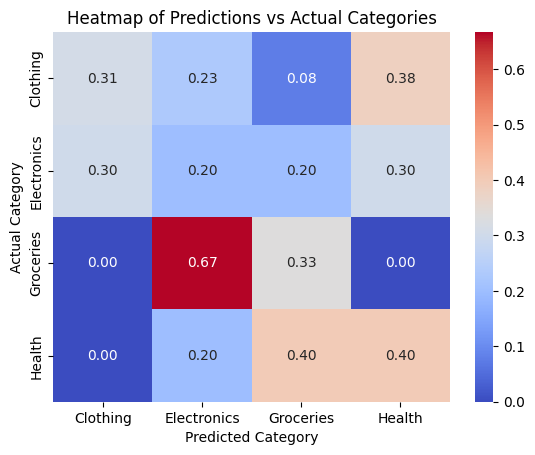

In [18]:
results["Correct"] = results["ActualCategory"] == results["PredictedCategory"]

sns.heatmap(pd.crosstab(results["ActualCategoryName"], results["PredictedCategoryName"], 
                        normalize='index'), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap of Predictions vs Actual Categories")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.show()
